In [1]:
import numpy as np
import os
import pandas as pd

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import seaborn as sns

import tensorflow as tf
from tensorflow import keras

from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings(action='ignore')

#한글설정
import matplotlib.font_manager as fm

font_dirs = ['/usr/share/fonts/truetype/nanum', ]
font_files = fm.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    fm.fontManager.addfont(font_file)
    
# 한글 출력을 위해서 폰트 옵션을 설정합니다.
# "axes.unicode_minus" : 마이너스가 깨질 것을 방지

sns.set(font="NanumBarunGothic",
        rc={"axes.unicode_minus":False},
        style='darkgrid')

#GPU 사용 설정, -1이면 CPU 사용
# os.environ["CUDA_VISIBLE_DEVICES"] = "0, 1"

gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:
    try:
        for i in range(len(gpus)):
            tf.config.experimental.set_memory_growth(gpus[i], True)
    except RuntimeError as e:
        # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
        print(e)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


# Method2 - 역전 마커
**FLOW**
1. method1 entropy를 d1-5 / d6-10으로 나눠서 적용
2. 원시간(d6-10) - 근시간(d1-5) 계산하여 순위 정렬
3. top10 정도만 absum 시각화

**method1 entropy**
- <div> $Score = {E(0to1) - E(1to0)} * Entropy$ </div>

In [2]:
path = '/project/LSH/'
model_path = path + 'model/allfit_ep500/allfit_ep500_seed42-17-0.7619.hdf5'

COLS = list(pd.read_csv(path + 'total_data_7727.csv')['ITEMID'].sort_values().unique())
x = np.load(path + 'x_(7727,10,4068).npy')
y = np.load(path + 'y_(7727,1).npy')

In [3]:
def entropy(ratio_list):
    one_ratio, zero_ratio = ratio_list[0], ratio_list[1] 
    if (one_ratio == 0) or (zero_ratio == 0):
        return 0.0
    return - ((one_ratio * (np.log2(one_ratio))) + (zero_ratio * (np.log2(zero_ratio))))

# def H(p):
#     id_p = np.where(p != 0)
#     return -np.sum(p[id_p]*np.log2(p[id_p]))

X = np.load('/project/LSH/x_(7727,10,4068).npy')

entropy_dict = {}
for i in tqdm(range(len(COLS))):
    one_ratio = X[:,:,i].sum() / (X.shape[0]*X.shape[1])
    zero_ratio = 1 - one_ratio
    entropy_num = entropy([one_ratio, zero_ratio])
    entropy_dict[COLS[i]] = entropy_num

  0%|          | 0/4068 [00:00<?, ?it/s]

# 원/근거리

In [ ]:
with tf.device('/device:GPU:0'): 
    model = tf.keras.models.load_model(model_path)
    result = []
    for i in tqdm(range(X.shape[2])):
        #-----#원거리#-----
        save_cols = X[:,:,i].copy()
        #-----zero2one-----
        X[:,:5,i] = 1
        원_pred1 = model.predict(X, batch_size=10000, workers=-1, use_multiprocessing=True)
        원_mean_pred1 = np.mean(원_pred1)
        #-----one2zero-----
        X[:,:5,i] = 0
        원_pred2 = model.predict(X, batch_size=10000, workers=-1, use_multiprocessing=True)
        원_mean_pred2 = np.mean(원_pred2)
        #-----값 복원-----
        X[:,:,i] = save_cols
        
        #-----#근거리#-----
        #-----zero2one-----
        X[:,5:,i] = 1
        근_pred1 = model.predict(X, batch_size=10000, workers=-1, use_multiprocessing=True)
        근_mean_pred1 = np.mean(근_pred1)
        #-----one2zero-----
        X[:,5:,i] = 0
        근_pred2 = model.predict(X, batch_size=10000, workers=-1, use_multiprocessing=True)
        근_mean_pred2 = np.mean(근_pred2)
        #-----값 복원-----
        X[:,:,i] = save_cols

        result.append({'feature' : str(COLS[i]),'원_lambda1' : (원_mean_pred1 - 원_mean_pred2) * entropy_dict[COLS[i]],
                       '근_lambda1' : (근_mean_pred1 - 근_mean_pred2)})        

In [ ]:
df = pd.DataFrame(result)
df

# py로 실행완료된 csv

In [29]:
df = pd.read_csv('./Result4.csv').sort_values('feature').reset_index(drop=True)
df['entropy'] = entropy_dict.values()
df['근_lambda1'] = df['근_lambda1'] * df['entropy']
df['sign'] = df['근_lambda1'].apply(lambda x:1 if x>=0 else -1)
df['역전성'] = df['원_lambda1'] * df['근_lambda1']
df = df.sort_values('역전성')

In [34]:
df[df['sign']==1][:6]

,feature,원_lambda1,근_lambda1,entropy,sign,역전성
3415,54569523500,-0.005889,0.025129,0.471125,1,-0.000148
5,50808,-0.006212,0.016105,0.342257,1,-0.000100
362,225752,-0.005758,0.012456,0.350231,1,-0.000072
12,50821,-0.006722,0.010304,0.692884,1,-0.000069
2,50804,-0.004728,0.013332,0.484874,1,-0.000063
2487,703115303,-0.002490,0.018646,0.213997,1,-0.000046


In [35]:
df[df['sign']==-1][:6]

,feature,원_lambda1,근_lambda1,entropy,sign,역전성
174,51221,0.005020,-0.013104,0.938478,-1,-0.000066
2452,641040025,0.003620,-0.011077,0.695030,-1,-0.000040
3832,63323026201,0.000815,-0.045708,0.795432,-1,-0.000037
3550,58177000111,0.001773,-0.014402,0.290479,-1,-0.000026
1510,88222033,0.004460,-0.005510,0.358055,-1,-0.000025
2611,904224461,0.003616,-0.006629,0.557009,-1,-0.000024


In [11]:
df = pd.read_csv('./Result4_loss.csv')
df['역전성'] = df['원_lambda1'] * df['근_lambda1']
df = df.sort_values('역전성', ascending=False)

In [16]:
df[-10:][::-1]

,feature,원_lambda1,근_lambda1,역전성
1510,50821,-0.004151,0.018595,-0.000077
1508,50818,-0.004129,0.013193,-0.000054
1500,50804,-0.001997,0.024653,-0.000049
1509,50820,-0.001488,0.028121,-0.000042
1503,50808,-0.001044,0.026455,-0.000028
1504,50809,-0.000635,0.036065,-0.000023
17,10019003783,-0.001022,0.021715,-0.000022
554,225752,-0.001098,0.015282,-0.000017
7,10019002710,-0.001560,0.010427,-0.000016
3890,904224461,0.001001,-0.012269,-0.000012


# Visualization

In [36]:
X = np.load('/project/LSH/x_(7727,10,4068).npy')
y = np.load('/project/LSH/y_(7727,1).npy')
# 컬럼이름 로드
COLS = list(pd.read_csv('/project/LSH/total_data_7727.csv')['ITEMID'].sort_values().unique())

#death_index
d_index = np.where(y==1)[0]
#survive_index (퇴원 환자)
s_index = np.where(y==0)[0]

#사망/퇴원 환자 분리
d_X = X[d_index]
s_X = X[s_index]

result = []
result_s = []
#day - 10일
for d in range(10):
    #4068 - ITEM
    for f in range(d_X.shape[-1]):
        d_sum = d_X[:,d,f].sum()/d_X.shape[0]
        s_sum = s_X[:,d,f].sum()/s_X.shape[0]
        result.append({'cols':COLS[f], 'day':10-d,'per':d_sum})
        result_s.append({'cols':COLS[f], 'day':10-d,'per':s_sum})
        
d_df = pd.DataFrame(result).sort_values(['cols','day']).reset_index(drop=True)
s_df = pd.DataFrame(result_s).sort_values(['cols','day']).reset_index(drop=True)
d_df.shape, s_df.shape

def visualization(top10_list):
    plt.figure(figsize = (13,12), dpi=150)
    for i, f in enumerate(top10_list):
        plt.subplot(4,3,1+i)
        plt.title(f)
        ax = sns.lineplot(data = d_df[d_df['cols']==int(f)], x = 'day', y='per', label='사망')
        ax = sns.lineplot(data = s_df[s_df['cols']==int(f)], x = 'day', y='per', label='퇴원')
        ax.invert_xaxis()
        ax.legend(loc='upper left')
    plt.tight_layout()

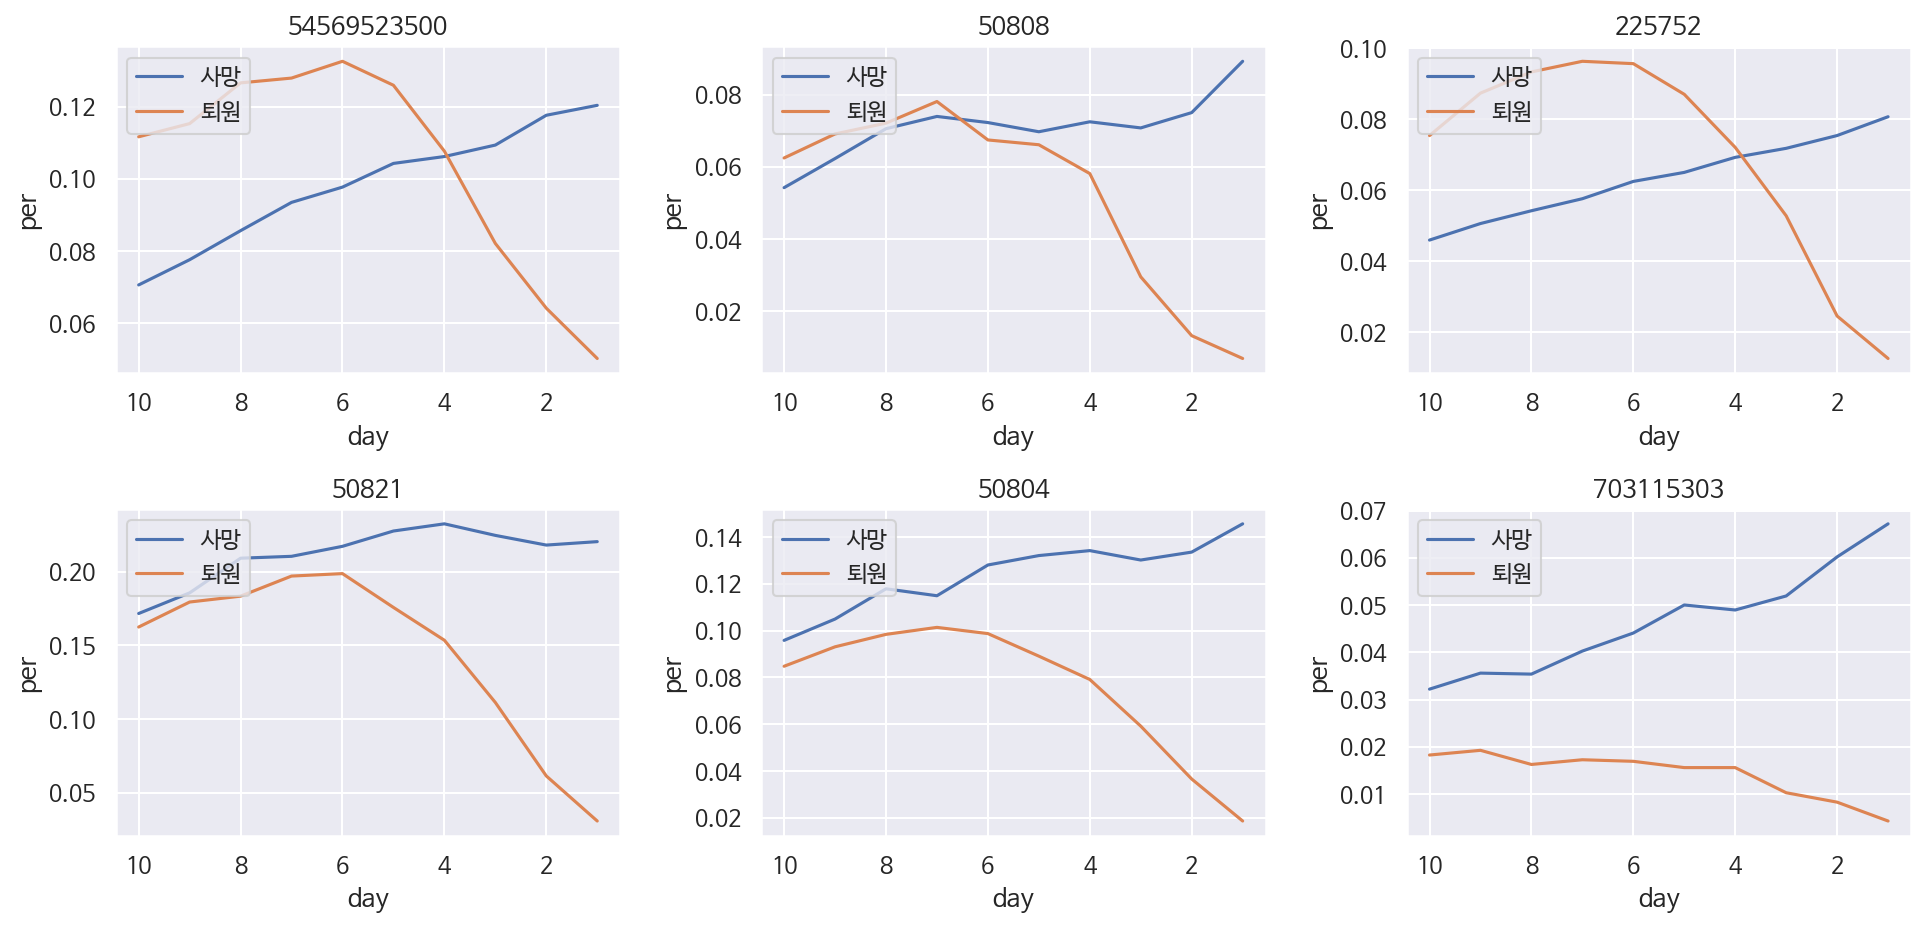

In [38]:
visualization(df[df['sign']==1][:6].feature)

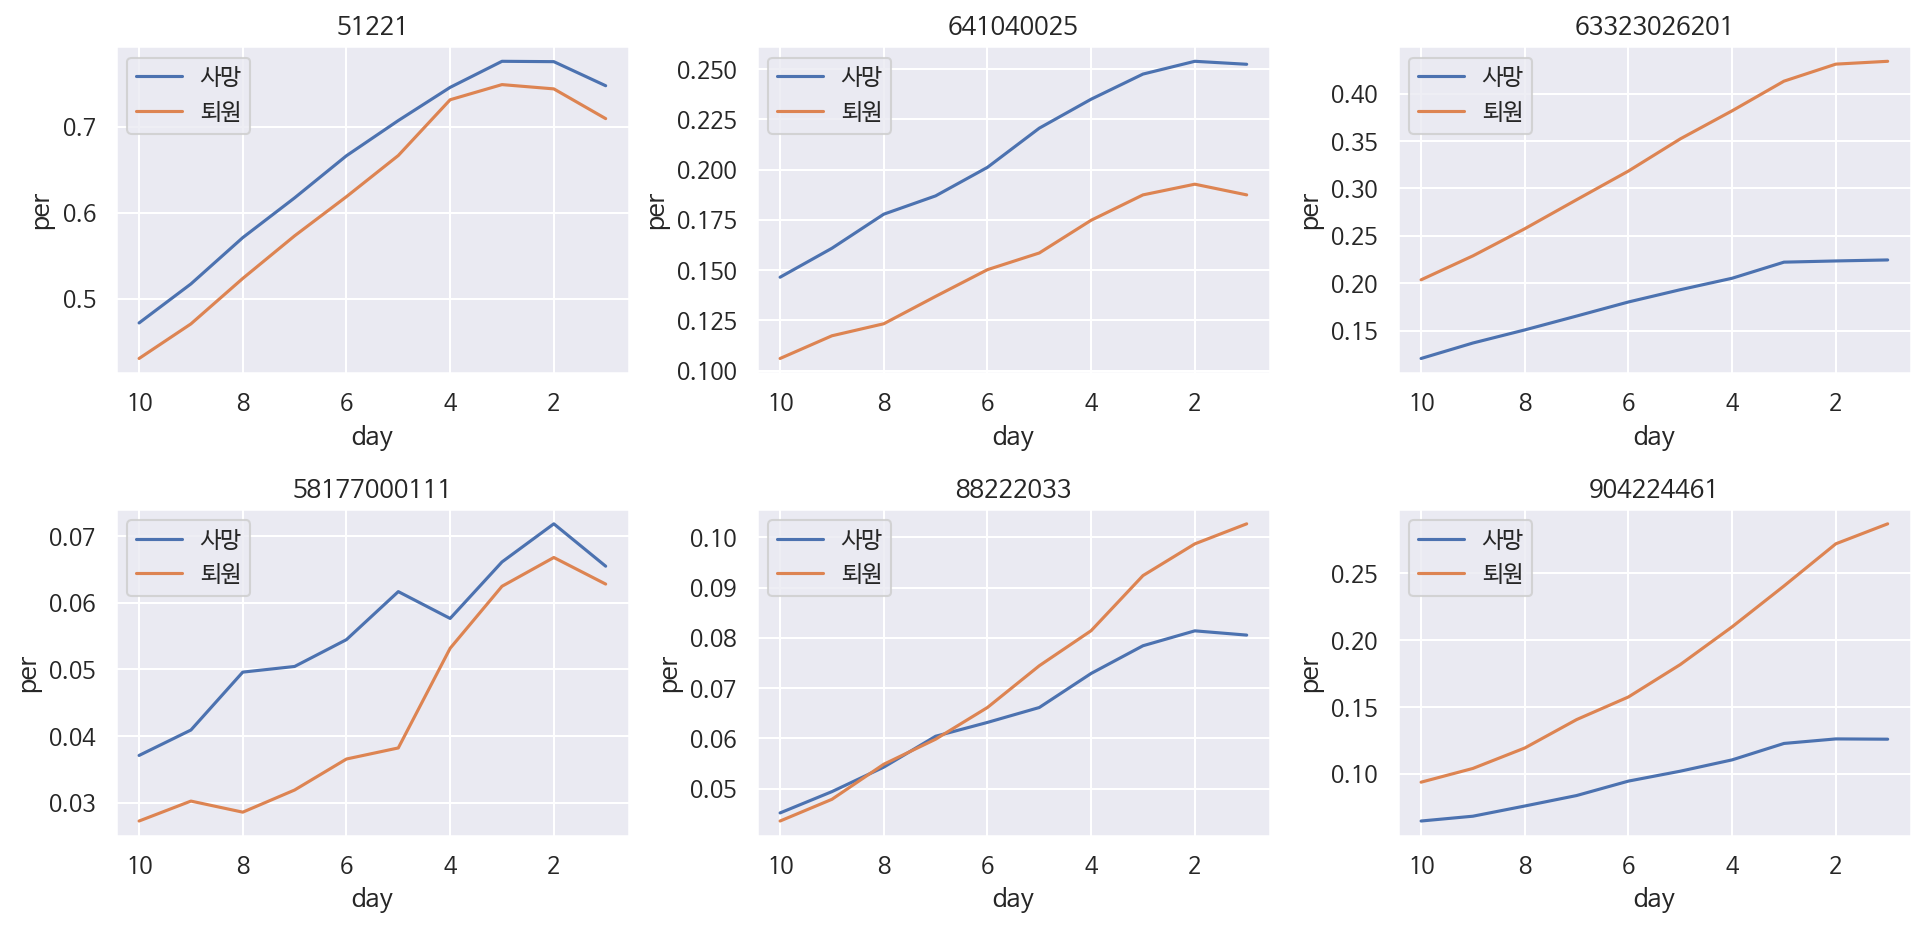

In [39]:
visualization(df[df['sign']==-1][:6].feature)

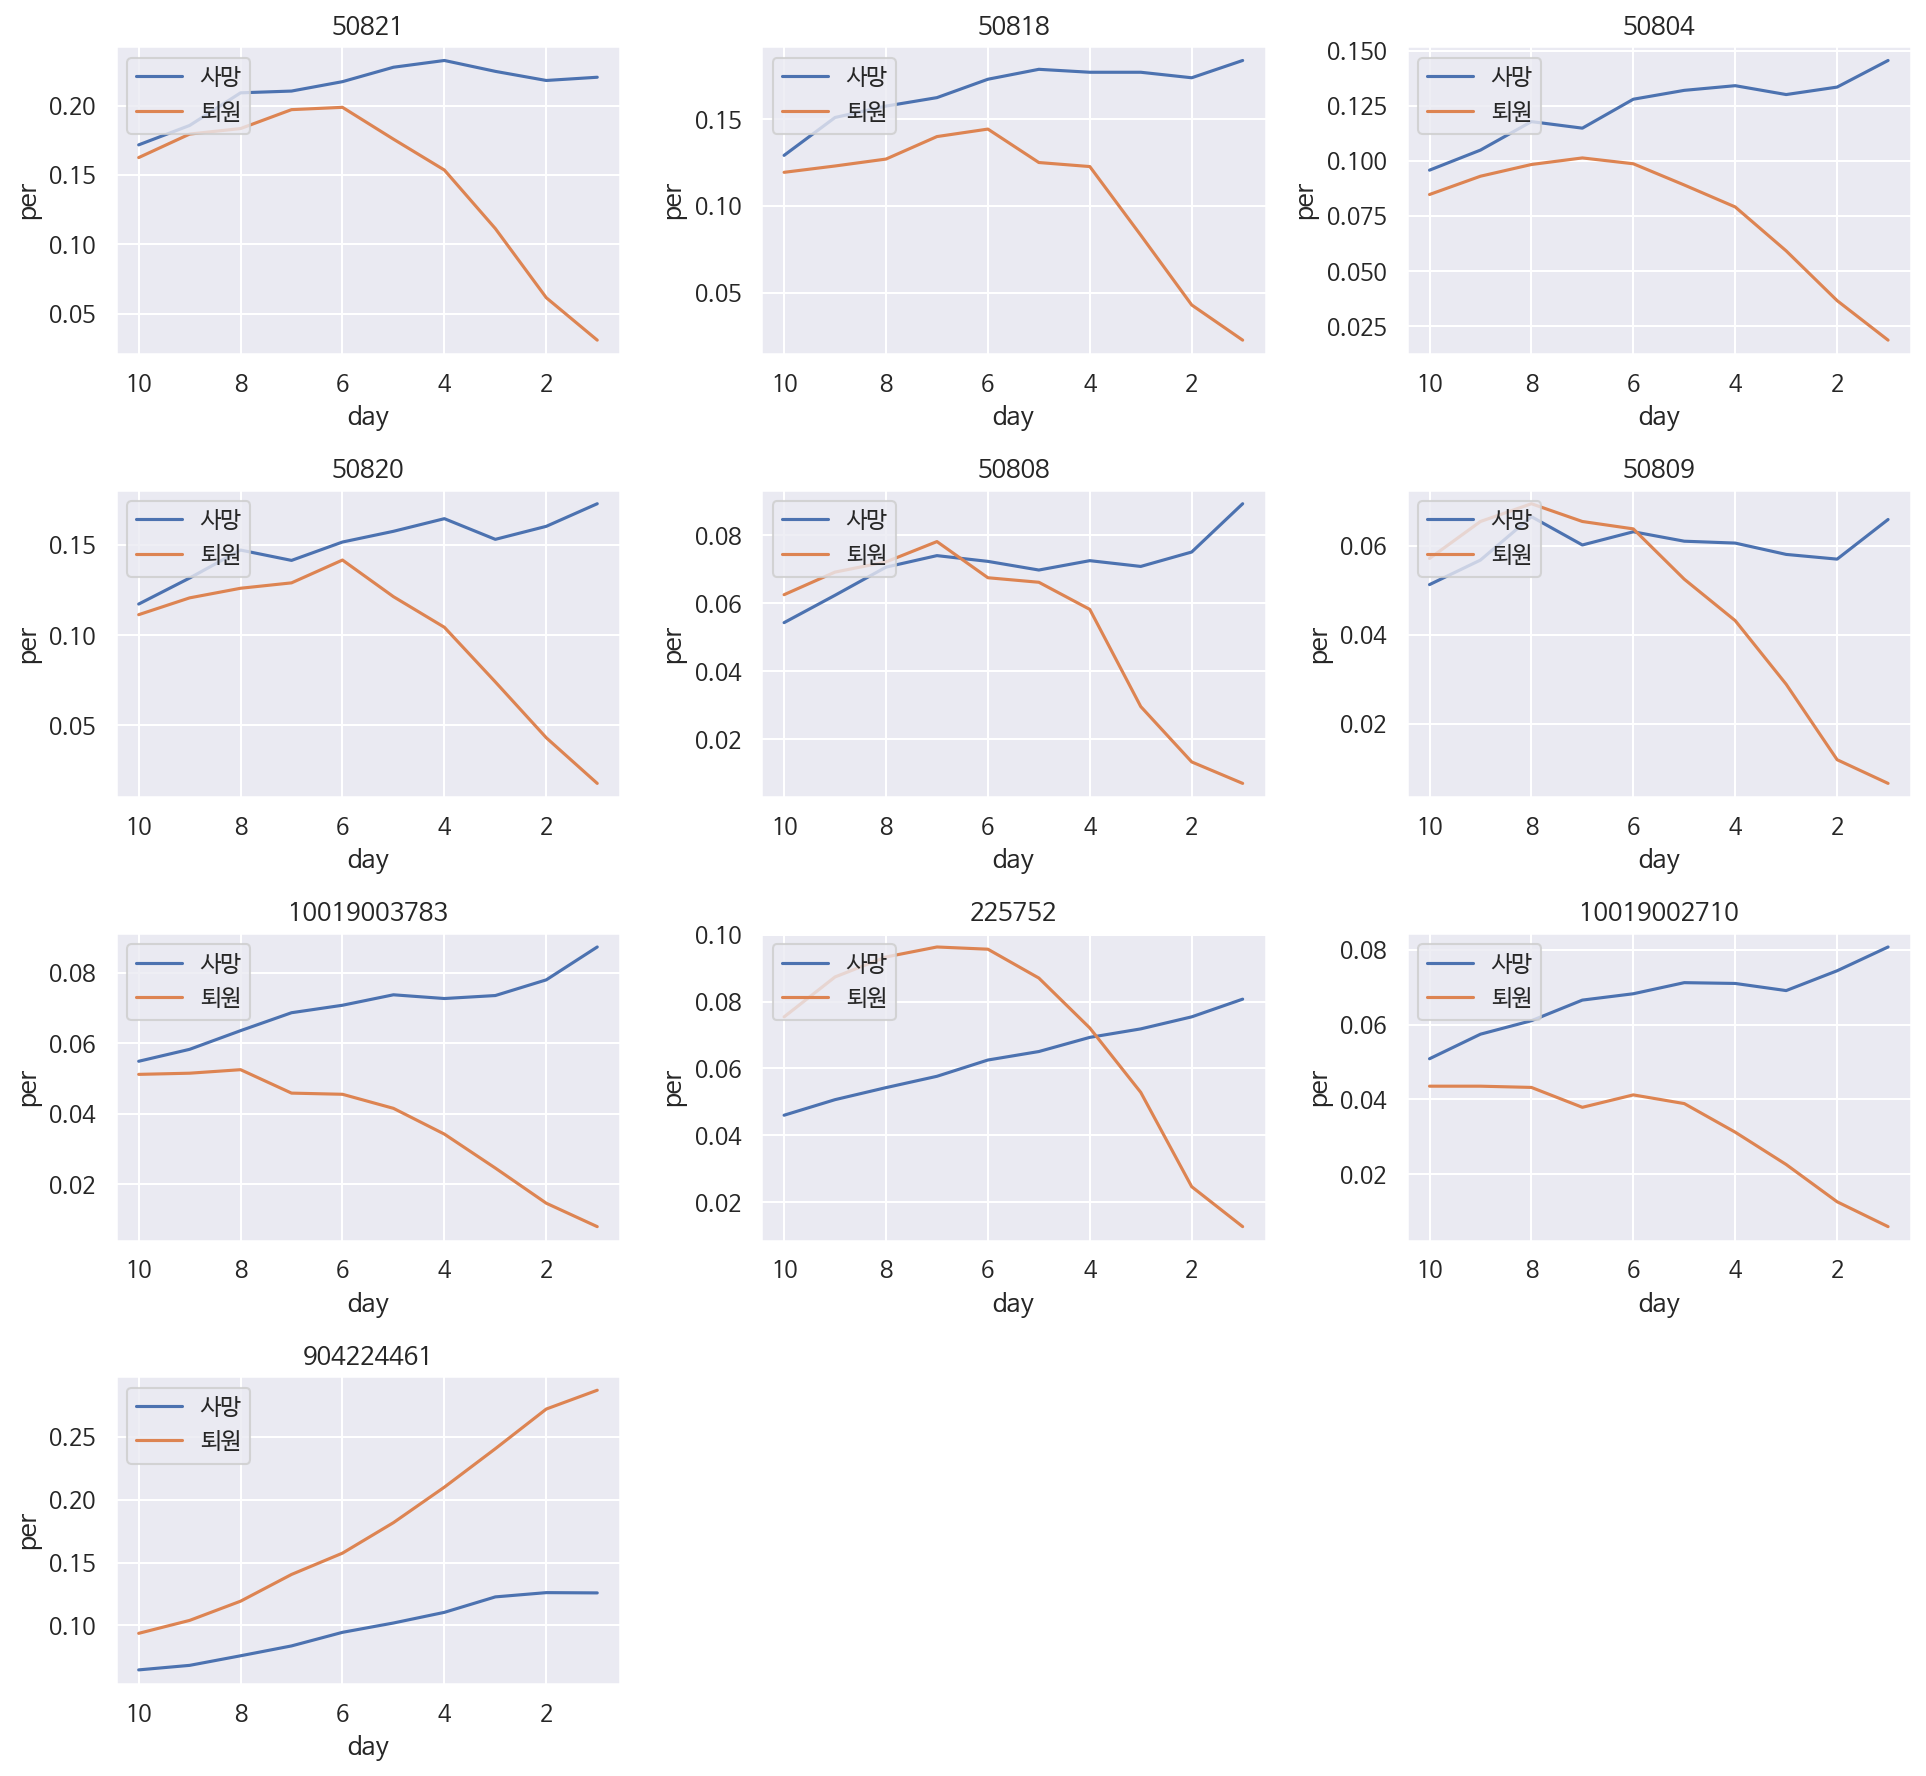

In [6]:
visualization(df.feature[-10:][::-1])